# Evochora — Data Analysis Guide

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/evochora/evochora/blob/main/notebooks/data_analysis_guide.ipynb?flush_cache=true)

This notebook shows how to analyze [Evochora](https://github.com/evochora/evochora) simulation data using standard scientific Python tools. All data is fetched live via the REST API — no file downloads, no special libraries.

**What you'll see:**
1. Population dynamics over time
2. A genome phylogenetic tree reconstructed from the simulation
3. Organism-level analysis: which genomes are "winning" and why
4. Cross-metric analysis with DuckDB SQL
5. A Muller Plot showing how lineage clades rise and fall over evolutionary time

**Requirements:** A running Evochora instance. Point `BASE_URL` below to your instance or use the public demo.

In [1]:
%%capture
!pip install duckdb

In [ ]:
# Point this to your Evochora instance
BASE_URL = "https://evochora.org"  # Public demo
# BASE_URL = "http://localhost:8081"  # Local instance

# Override auto-selection: uncomment and set a specific run ID
# RUN_ID = "20260216-21270780-fc077723-..."

import requests, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

def format_genome_hash(h):
    """Convert genome hash to 6-char Base62 string (matches Visualizer display)."""
    chars = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
    n = int(h)
    if n < 0:
        n += (1 << 64)
    result = ''
    for _ in range(6):
        result = chars[n % 62] + result
        n //= 62
    return result

# Select the simulation run to analyze
runs = requests.get(f"{BASE_URL}/analyzer/api/runs").json()

if 'RUN_ID' in dir() and RUN_ID:
    # Manual selection: verify the run exists
    valid_ids = {r['runId'] for r in runs}
    if RUN_ID not in valid_ids:
        print(f"WARNING: Run ID '{RUN_ID}' not found. Available runs:")
        for r in runs:
            print(f"  {r['runId']}")
        raise ValueError(f"Run ID '{RUN_ID}' not found on {BASE_URL}")
    print(f"Using manually selected run: {RUN_ID}")
elif len(runs) > 1:
    # Auto-select: pick the run with the highest maxTick
    best_run = None
    best_max_tick = -1
    for r in runs:
        t = requests.get(f"{BASE_URL}/visualizer/api/organisms/ticks",
                         params={"runId": r['runId']}).json()
        if t['maxTick'] > best_max_tick:
            best_max_tick = t['maxTick']
            best_run = r['runId']
    RUN_ID = best_run
    print(f"Auto-selected run {RUN_ID} ({best_max_tick:,} ticks) from {len(runs)} available runs")
else:
    RUN_ID = runs[0]['runId']

# Helper: add runId to all API requests
run_params = {"runId": RUN_ID}

ticks = requests.get(f"{BASE_URL}/visualizer/api/organisms/ticks", params=run_params).json()
manifest = requests.get(f"{BASE_URL}/analyzer/api/manifest", params=run_params).json()
sim_metadata = requests.get(f"{BASE_URL}/visualizer/api/simulation/metadata", params=run_params).json()

TICK_INTERVAL = sim_metadata.get('samplingInterval', 1000)

# Extract thermodynamic limits from resolved config
resolved_config = json.loads(sim_metadata.get('resolvedConfigJson', '{}'))
runtime_cfg = resolved_config.get('runtime', {}).get('organism', {})
MAX_ENERGY = runtime_cfg.get('max-energy', 32767)
MAX_ENTROPY = runtime_cfg.get('max-entropy', 8191)

print(f"Connected to {BASE_URL}")
print(f"Run ID: {RUN_ID}")
print(f"Tick range: {ticks['minTick']:,} to {ticks['maxTick']:,}")
print(f"Organism indexing interval: {TICK_INTERVAL:,}")
print(f"Max energy: {MAX_ENERGY:,}  Max entropy: {MAX_ENTROPY:,}")
print(f"\nAvailable metrics:")
for m in manifest['metrics']:
    print(f"  {m['id']:30s} {m['name']}")

---
## 1. Population Dynamics

The `population` metric tracks the number of living organisms, their average energy, and average entropy at each sampled tick. This is the pulse of the simulation.

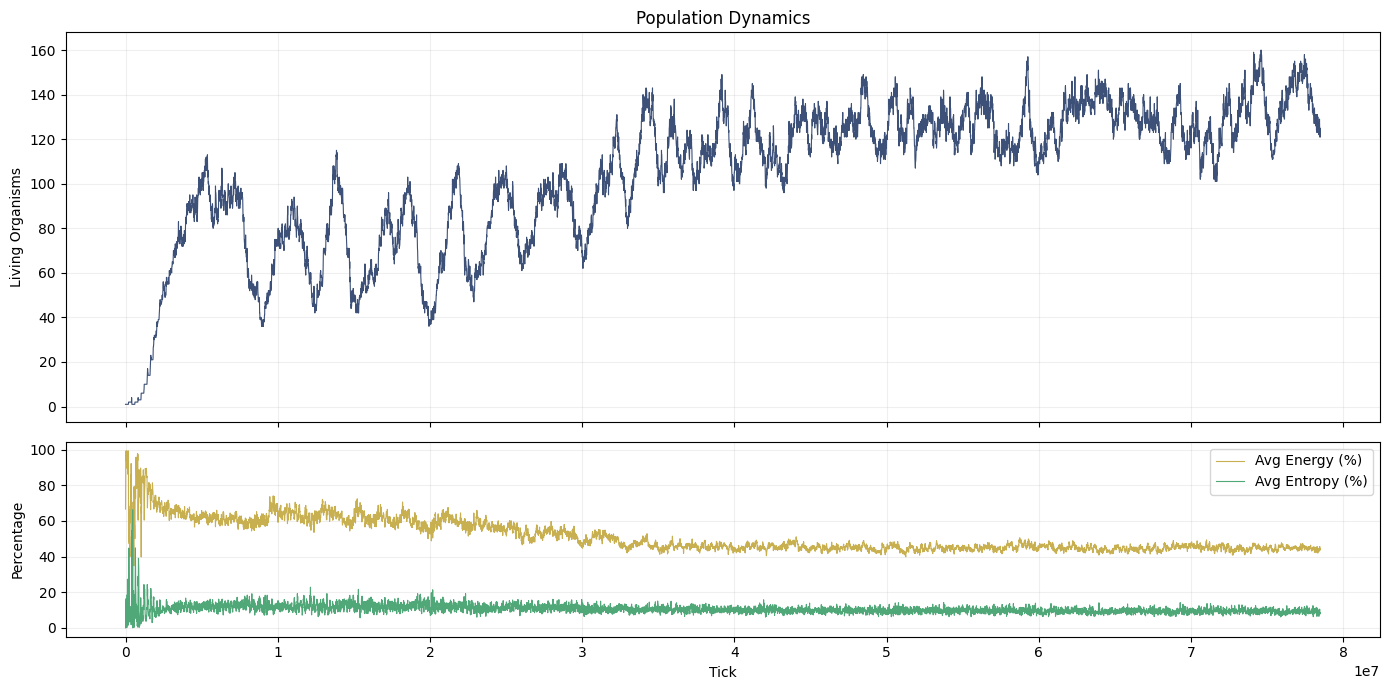

Peak population: 160
Final population: 121


In [3]:
pop = pd.DataFrame(requests.get(
    f"{BASE_URL}/analyzer/api/data",
    params={**run_params, "metric": "population", "lod": "lod2"}
).json())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True,
                                gridspec_kw={'height_ratios': [2, 1]})

ax1.plot(pop['tick'], pop['alive_count'], color='#3c5078', linewidth=0.8)
ax1.set_ylabel('Living Organisms')
ax1.set_title('Population Dynamics')
ax1.grid(alpha=0.2)

ax2.plot(pop['tick'], pop['avg_energy'], color='#c8af50', linewidth=0.8, label='Avg Energy (%)')
ax2.plot(pop['tick'], pop['avg_entropy'], color='#50a878', linewidth=0.8, label='Avg Entropy (%)')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Percentage')
ax2.legend(loc='upper right')
ax2.grid(alpha=0.2)

plt.tight_layout()
plt.show()

print(f"Peak population: {pop['alive_count'].max()}")
print(f"Final population: {pop['alive_count'].iloc[-1]}")

---
## 2. Genome Phylogenetic Tree

Every time a mutation creates a new genome during reproduction, Evochora records the parent-child relationship. The Visualizer API returns the complete `genomeLineageTree` — a mapping from each genome hash to its parent genome hash.

From this single data structure, we can reconstruct the entire evolutionary tree: which lineages radiated, which went extinct, and which are still alive today.

In [4]:
# Fetch organism data at the latest available tick
latest_tick = ticks['maxTick']
data = requests.get(f"{BASE_URL}/visualizer/api/organisms/{latest_tick}", params=run_params).json()

organisms = data['organisms']
tree_raw = data['genomeLineageTree']
total_created = data['totalOrganismCount']
alive = [o for o in organisms if not o['isDead']]

print(f"Simulation at tick {latest_tick:,}")
print(f"  Organisms ever created:  {total_created:,}")
print(f"  Currently alive:         {len(alive):,}")
print(f"  Unique genomes observed: {len(tree_raw):,}")

# Build directed graph: edge from parent genome -> child genome
G = nx.DiGraph()
for genome, parent in tree_raw.items():
    G.add_node(genome)
    if parent is not None:
        G.add_edge(parent, genome)

# Count living organisms per genome
genome_pop = {}
for o in alive:
    gh = o['genomeHash']
    genome_pop[gh] = genome_pop.get(gh, 0) + 1

active_genomes = set(genome_pop.keys())
roots = [n for n in G.nodes() if G.in_degree(n) == 0]

# Compute evolutionary depth for each genome
depths = {}
for root in roots:
    for node in nx.descendants(G, root) | {root}:
        try:
            d = nx.shortest_path_length(G, root, node)
            depths[node] = max(depths.get(node, 0), d)
        except nx.NetworkXNoPath:
            pass

print(f"\n  Root genomes (primordial): {len(roots)}")
print(f"  Active genomes:           {len(active_genomes)} (with living organisms)")
if depths:
    print(f"  Max evolutionary depth:   {max(depths.values())} mutations from primordial")
    print(f"  Avg evolutionary depth:   {np.mean(list(depths.values())):.1f}")

# Prune: keep only paths from roots to currently active genomes
keep = set()
for genome in active_genomes:
    node = genome
    while node is not None:
        if node in keep:
            break
        keep.add(node)
        parents = list(G.predecessors(node))
        node = parents[0] if parents else None

G_pruned = G.subgraph(keep).copy()
print(f"\n  Pruned to active lineages: {G_pruned.number_of_nodes()} genomes")
print(f"  (only lineages leading to currently living organisms)")

Simulation at tick 78,990,000
  Organisms ever created:  33,472
  Currently alive:         141
  Unique genomes observed: 12,900

  Root genomes (primordial): 2
  Active genomes:           76 (with living organisms)
  Max evolutionary depth:   28 mutations from primordial
  Avg evolutionary depth:   12.6

  Pruned to active lineages: 164 genomes
  (only lineages leading to currently living organisms)


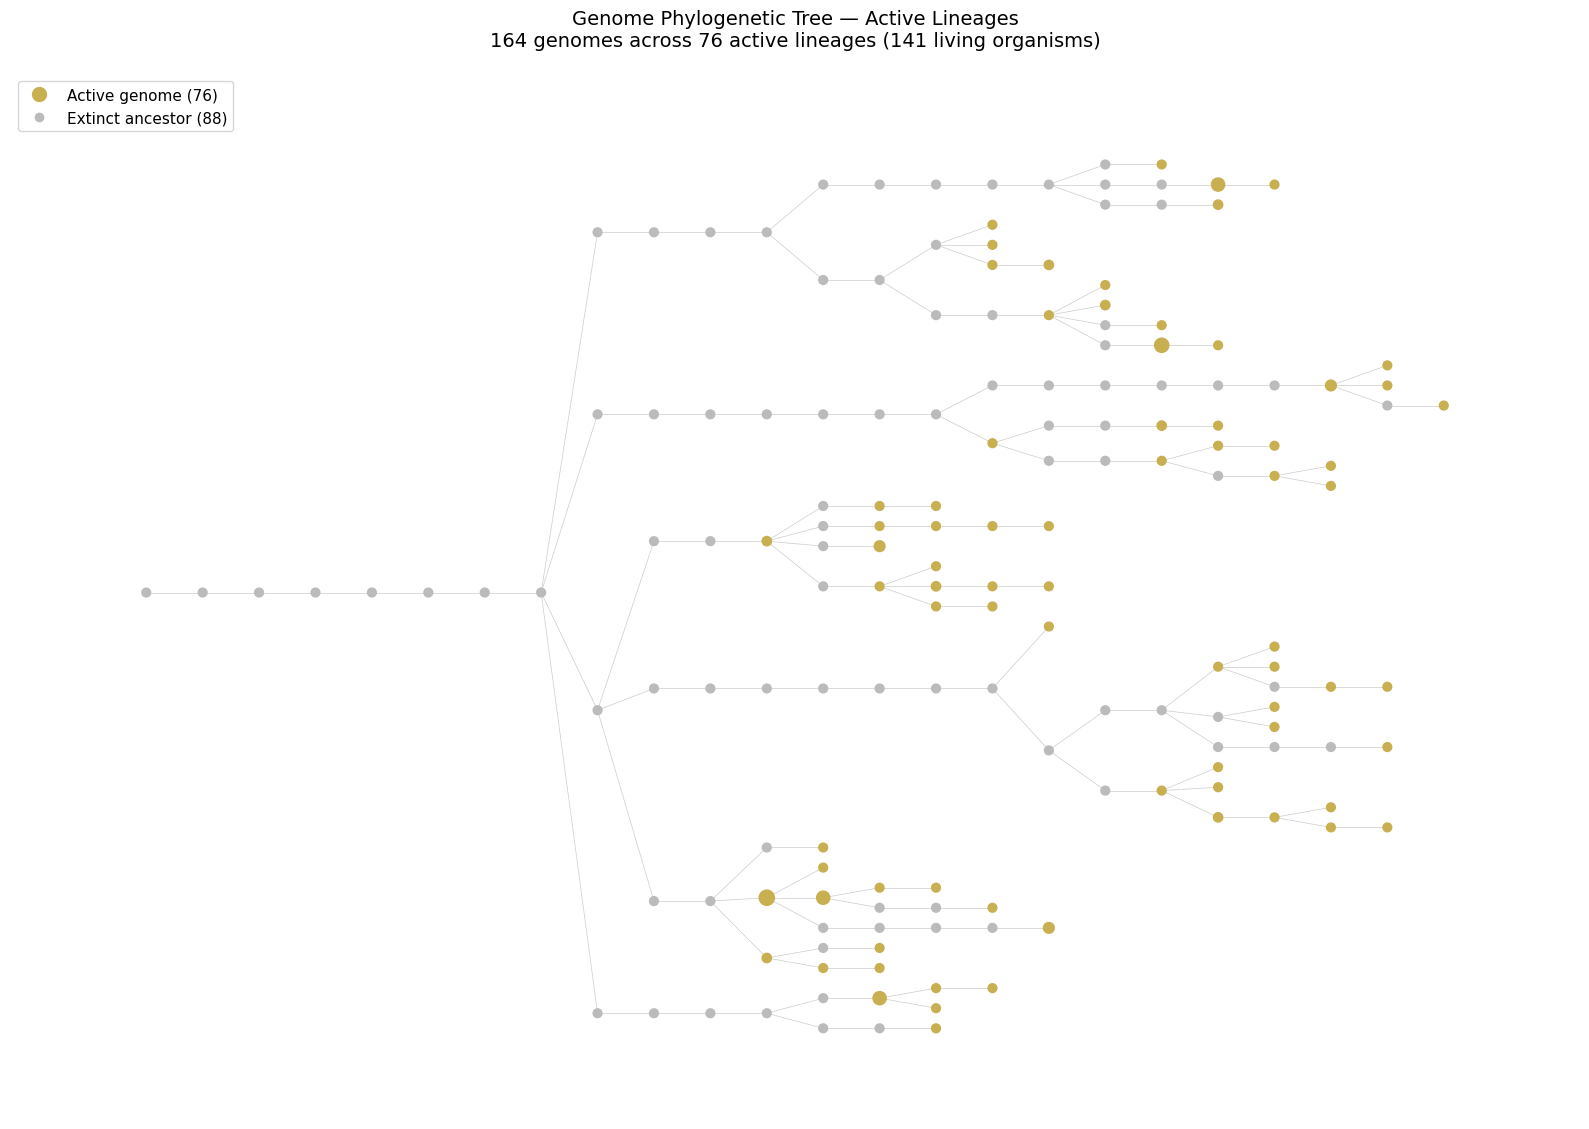

In [5]:
def tree_layout(G, roots):
    """Horizontal tree layout: root on the left, leaves on the right."""
    pos = {}
    leaf_cache = {}

    def count_leaves(node):
        if node in leaf_cache:
            return leaf_cache[node]
        children = list(G.successors(node))
        result = 1 if not children else sum(count_leaves(c) for c in children)
        leaf_cache[node] = result
        return result

    def place(node, top, bottom, depth):
        children = list(G.successors(node))
        if not children:
            pos[node] = (depth, (top + bottom) / 2)
            return
        sizes = [count_leaves(c) for c in children]
        total = sum(sizes)
        y = top
        for child, size in zip(children, sizes):
            h = (bottom - top) * size / total
            place(child, y, y + h, depth + 1)
            y += h
        child_ys = [pos[c][1] for c in children]
        pos[node] = (depth, np.mean(child_ys))

    total_leaves = sum(count_leaves(r) for r in roots)
    y = 0
    for root in roots:
        sz = count_leaves(root)
        h = sz / total_leaves if total_leaves > 0 else 1
        place(root, y, y + h, 0)
        y += h
    return pos

pruned_roots = [n for n in G_pruned.nodes() if G_pruned.in_degree(n) == 0]
pos = tree_layout(G_pruned, pruned_roots)

# Node styling: gold = active genome, gray = extinct ancestor
node_sizes = [max(40, genome_pop.get(n, 0) * 15) for n in G_pruned.nodes()]
node_colors = ['#c8af50' if n in active_genomes else '#bbbbbb' for n in G_pruned.nodes()]

height = max(10, len(active_genomes) * 0.15)
fig, ax = plt.subplots(figsize=(16, height))
nx.draw(G_pruned, pos, ax=ax,
        node_size=node_sizes, node_color=node_colors,
        edge_color='#cccccc', width=0.5,
        arrows=False, with_labels=False)

ax.set_title(
    f'Genome Phylogenetic Tree — Active Lineages\n'
    f'{G_pruned.number_of_nodes()} genomes across '
    f'{len(active_genomes)} active lineages '
    f'({len(alive)} living organisms)',
    fontsize=14, pad=20)

legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#c8af50',
           markersize=12, label=f'Active genome ({len(active_genomes)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#bbbbbb',
           markersize=8, label=f'Extinct ancestor ({G_pruned.number_of_nodes() - len(active_genomes)})'),
]
ax.legend(handles=legend, loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()

Each gold node is a genome with living organisms right now. Gray nodes are extinct ancestors — genomes that no longer have any living carriers but whose mutations led to the genomes alive today. The tree reads left to right: root (primordial genome) on the left, most recent mutations on the right.

Node size reflects how many organisms carry that genome. Branches that split early and spread wide indicate successful evolutionary radiations.

---
## 3. Population Census

Which genomes dominate the population? How old are their organisms? Do different genomes show different survival characteristics? Let's look at the living organisms grouped by genome.

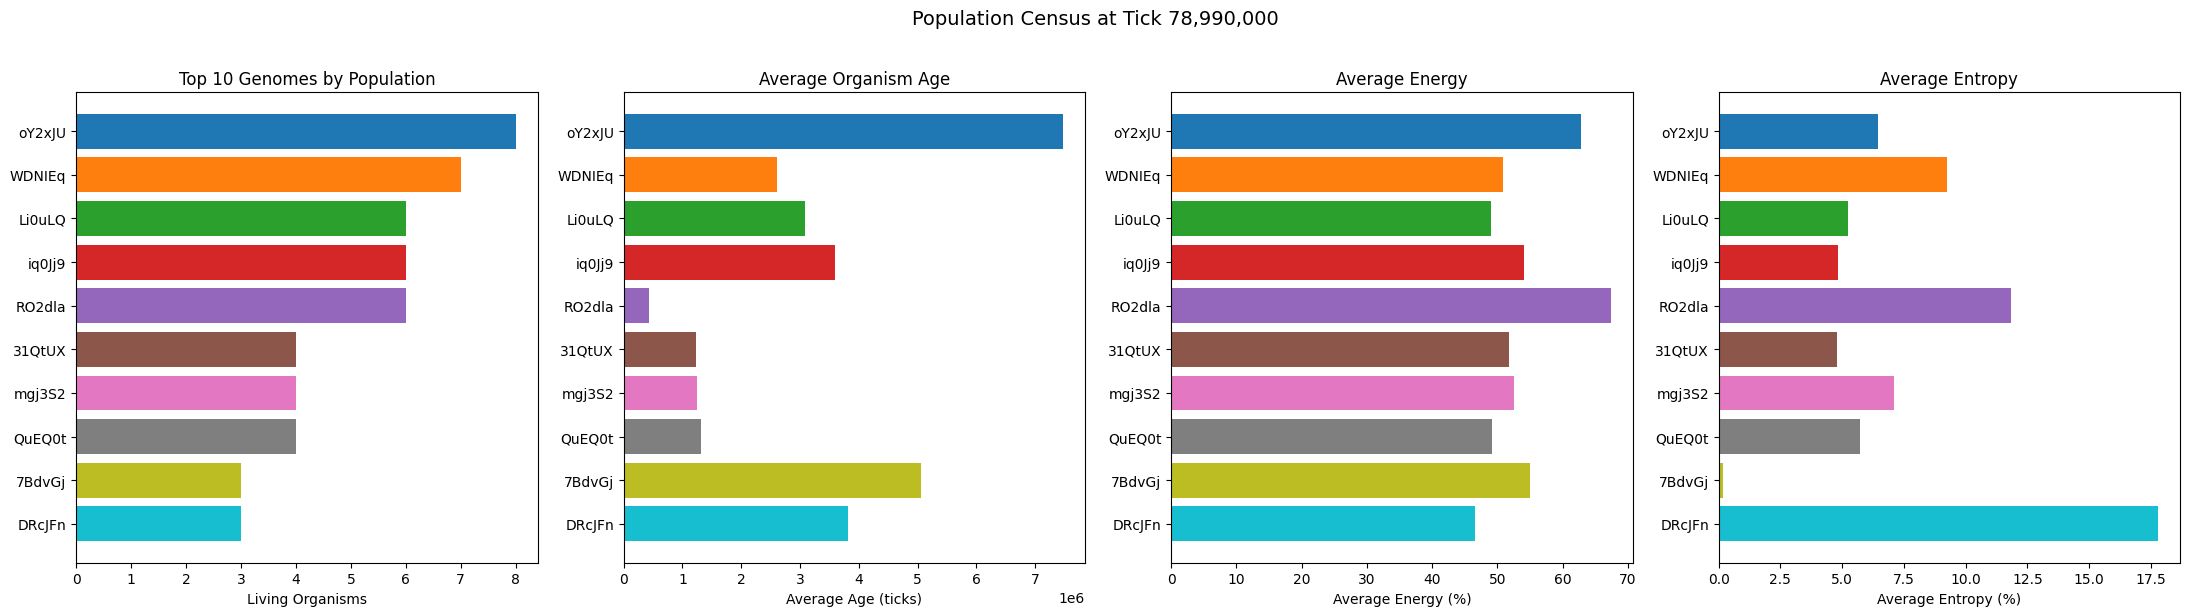

  Genome    Pop       Avg Age   Energy %   Entropy %   Depth
------------------------------------------------------------
  oY2xJU      8     7,474,970      62.8%        6.5%      11
  WDNIEq      7     2,608,214      50.8%        9.2%      18
  Li0uLQ      6     3,076,908      49.1%        5.2%      12
  iq0Jj9      6     3,587,680      54.1%        4.8%      13
  RO2dla      6       438,835      67.4%       11.8%      19
  31QtUX      4     1,227,016      51.8%        4.8%      16
  mgj3S2      4     1,249,944      52.5%        7.1%      13
  QuEQ0t      4     1,321,290      49.2%        5.7%      21
  7BdvGj      3     5,059,367      55.0%        0.2%      11
  DRcJFn      3     3,819,237      46.6%       17.8%      11


In [6]:
# Group living organisms by genome
genome_stats = {}
for o in alive:
    gh = o['genomeHash']
    age = latest_tick - o['birthTick']
    genome_stats.setdefault(gh, []).append({
        'age': age,
        'energy_pct': o['energy'] / MAX_ENERGY * 100,
        'entropy_pct': o['entropyRegister'] / MAX_ENTROPY * 100
    })

# Sort by population size
top = sorted(genome_stats.items(), key=lambda x: -len(x[1]))[:10]
colors = plt.cm.tab10(np.linspace(0, 1, len(top)))

fig, axes = plt.subplots(1, 4, figsize=(22, 6))

labels = [format_genome_hash(gh) for gh, _ in top]
counts = [len(orgs) for _, orgs in top]

# Population
axes[0].barh(labels, counts, color=colors)
axes[0].set_xlabel('Living Organisms')
axes[0].set_title('Top 10 Genomes by Population')
axes[0].invert_yaxis()

# Average age
avg_ages = [np.mean([o['age'] for o in orgs]) for _, orgs in top]
axes[1].barh(labels, avg_ages, color=colors)
axes[1].set_xlabel('Average Age (ticks)')
axes[1].set_title('Average Organism Age')
axes[1].invert_yaxis()

# Average energy %
avg_energy = [np.mean([o['energy_pct'] for o in orgs]) for _, orgs in top]
axes[2].barh(labels, avg_energy, color=colors)
axes[2].set_xlabel('Average Energy (%)')
axes[2].set_title('Average Energy')
axes[2].invert_yaxis()

# Average entropy %
avg_entropy = [np.mean([o['entropy_pct'] for o in orgs]) for _, orgs in top]
axes[3].barh(labels, avg_entropy, color=colors)
axes[3].set_xlabel('Average Entropy (%)')
axes[3].set_title('Average Entropy')
axes[3].invert_yaxis()

plt.suptitle(f'Population Census at Tick {latest_tick:,}', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print(f"{'Genome':>8s}  {'Pop':>5s}  {'Avg Age':>12s}  {'Energy %':>9s}  {'Entropy %':>10s}  {'Depth':>6s}")
print('-' * 60)
for gh, orgs in top:
    avg_a = np.mean([o['age'] for o in orgs])
    avg_e = np.mean([o['energy_pct'] for o in orgs])
    avg_s = np.mean([o['entropy_pct'] for o in orgs])
    d = depths.get(gh, '?')
    print(f"{format_genome_hash(gh):>8s}  {len(orgs):5d}  {avg_a:12,.0f}  {avg_e:8.1f}%  {avg_s:9.1f}%  {d:>6}")

---
## 4. Cross-Metric Analysis with DuckDB

The built-in Analyzer dashboard shows each metric independently. With DuckDB, we can join metrics and ask questions that span multiple datasets — something the dashboard can't do.

**Question:** Is there a relationship between population size and genome diversity? Population genetics predicts that larger populations should sustain more genetic diversity.

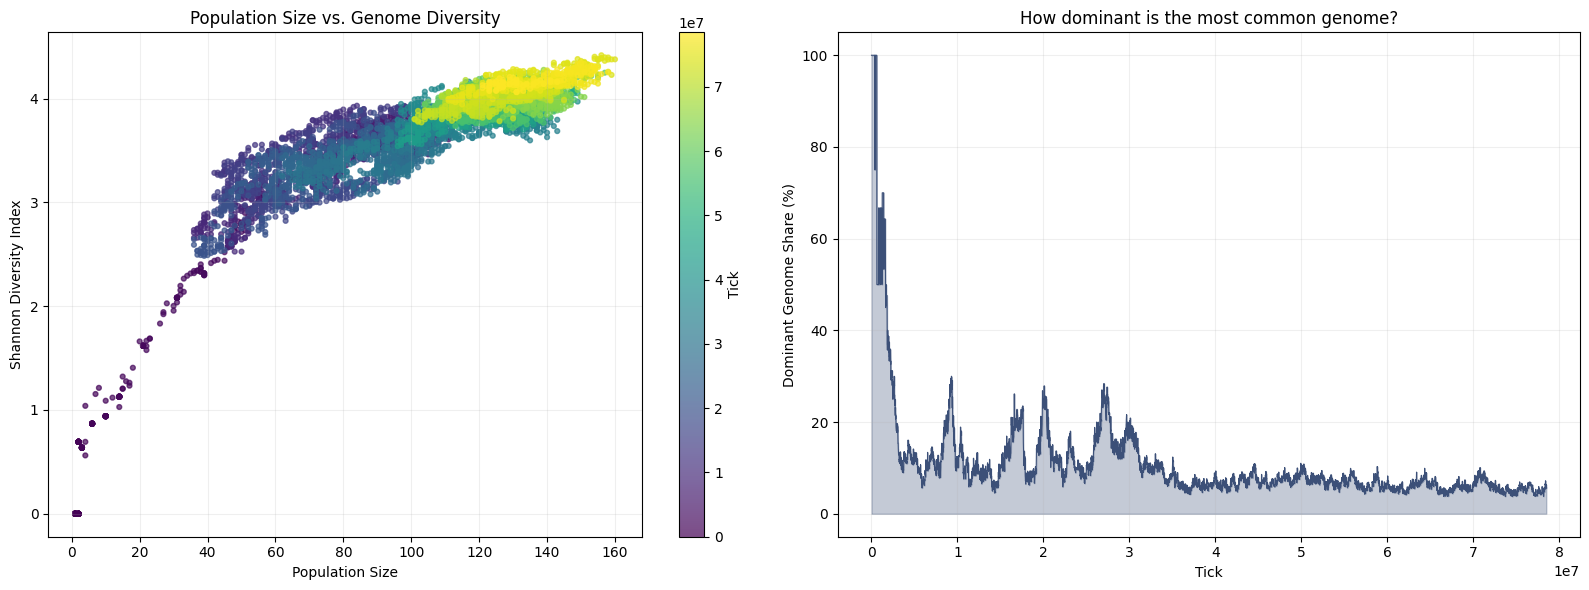

Pearson correlation (population vs. diversity): 0.859
Lowest dominant share:  3.8%
Highest dominant share: 100.0%


In [7]:
import duckdb

# Fetch genome diversity metric
div = pd.DataFrame(requests.get(
    f"{BASE_URL}/analyzer/api/data",
    params={**run_params, "metric": "genome_diversity", "lod": "lod2"}
).json())

# DuckDB: join population and diversity by tick
con = duckdb.connect()
con.register('population', pop)
con.register('diversity', div)

result = con.execute("""
    SELECT p.tick,
           p.alive_count,
           d.shannon_index,
           d.active_genomes,
           d.dominant_share
    FROM population p
    JOIN diversity d ON p.tick = d.tick
    WHERE p.alive_count > 0
    ORDER BY p.tick
""").fetchdf()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: population size vs diversity (colored by time)
sc = axes[0].scatter(result['alive_count'], result['shannon_index'],
                     c=result['tick'], cmap='viridis', s=12, alpha=0.7)
plt.colorbar(sc, ax=axes[0], label='Tick')
axes[0].set_xlabel('Population Size')
axes[0].set_ylabel('Shannon Diversity Index')
axes[0].set_title('Population Size vs. Genome Diversity')
axes[0].grid(alpha=0.2)

# Right: dominant genome share over time
axes[1].fill_between(result['tick'], result['dominant_share'] * 100,
                     alpha=0.3, color='#3c5078')
axes[1].plot(result['tick'], result['dominant_share'] * 100,
             color='#3c5078', linewidth=0.8)
axes[1].set_xlabel('Tick')
axes[1].set_ylabel('Dominant Genome Share (%)')
axes[1].set_title('How dominant is the most common genome?')
axes[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

# Correlation analysis
corr = result[['alive_count', 'shannon_index']].corr().iloc[0, 1]
print(f"Pearson correlation (population vs. diversity): {corr:.3f}")
print(f"Lowest dominant share:  {result['dominant_share'].min() * 100:.1f}%")
print(f"Highest dominant share: {result['dominant_share'].max() * 100:.1f}%")

---
## 5. Muller Plot — Evolutionary Dynamics Over Time

A [Muller Plot](https://en.wikipedia.org/wiki/Muller_plot) is the gold standard visualization in experimental evolution research. It shows how different lineages rise and fall over time as nested stacked areas — child lineages are visually nested inside their parents, making it easy to see how new mutations emerge *within* an existing population and either take over or go extinct.

**Challenge:** Evochora simulations produce extreme genetic diversity — thousands of unique genomes, most differing by just one or two neutral mutations. Tracking every individual genome would produce visual noise. Instead, we group genomes into **clades** (lineage families) by walking up the phylogenetic tree to a common ancestor at a certain depth. The algorithm automatically selects the depth that produces a readable number of clades.

This cell samples the Visualizer API at ~200 time points. Expect it to run for 1-2 minutes depending on your simulation size.

Sampling 200 ticks from 1,420,000 to 78,990,000 (interval: 10,000)
  50/200 — tick   20,520,000: 55 organisms, 20 genomes
  100/200 — tick   40,010,000: 107 organisms, 56 genomes
  150/200 — tick   59,500,000: 124 organisms, 78 genomes
  200/200 — tick   78,990,000: 141 organisms, 76 genomes

Auto-selected clade depth: 8 (max tree depth: 28)
Tracking 63 clades: 19651/21037 organism-ticks (93%)


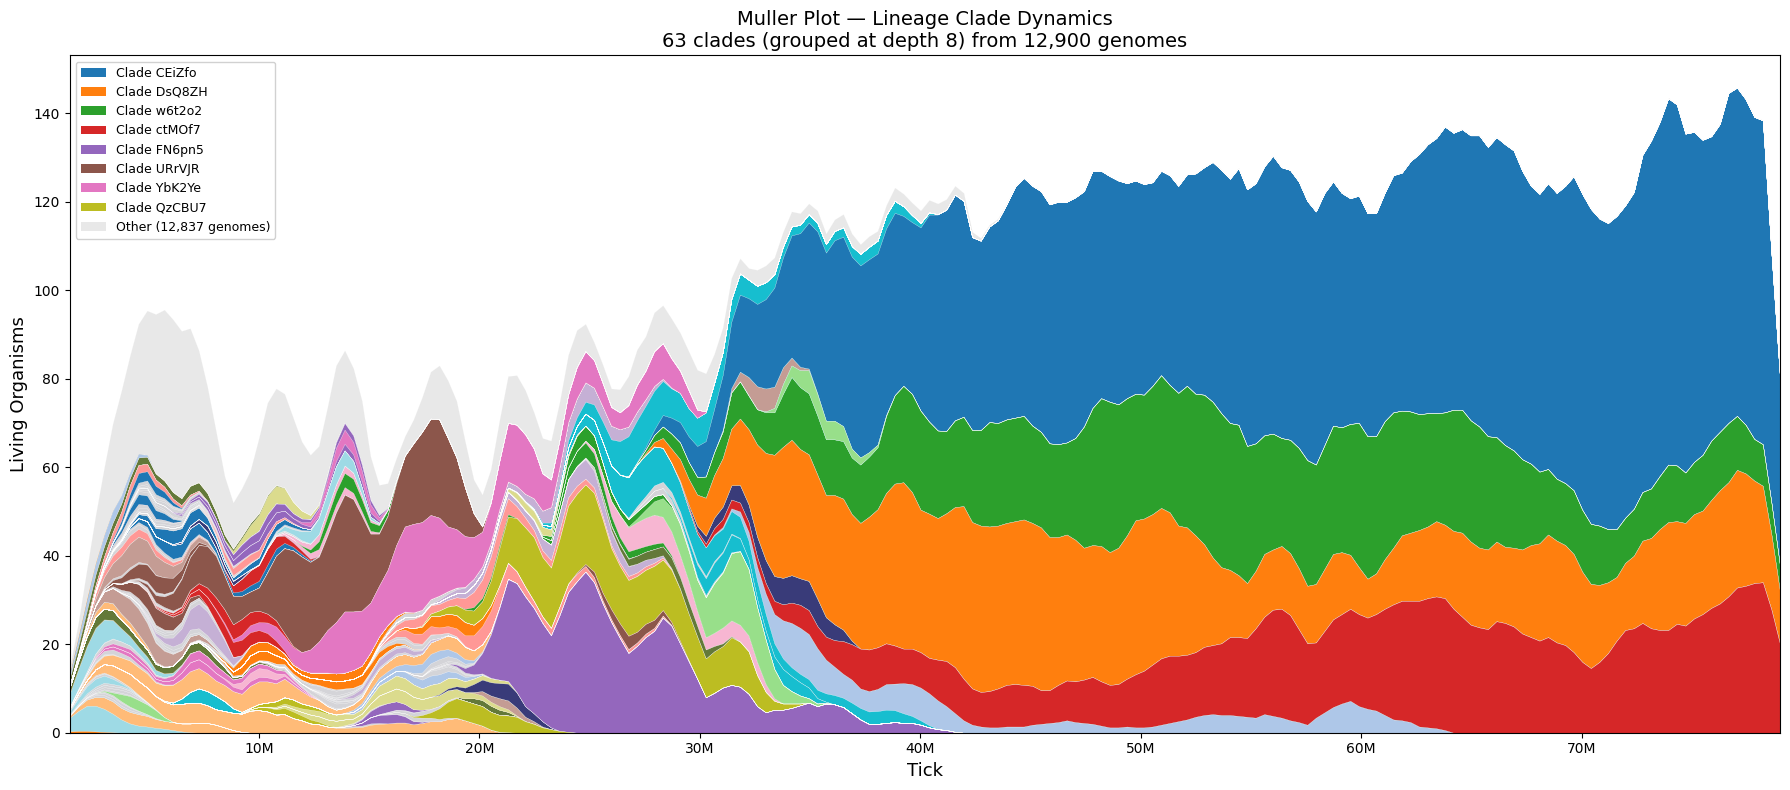


Top clades by total organism-ticks:
  1. CEiZfo   6,799 (32.3%)
  2. DsQ8ZH   2,998 (14.3%)
  3. w6t2o2   2,610 (12.4%)
  4. ctMOf7   2,070 ( 9.8%)
  5. FN6pn5     739 ( 3.5%)
  6. URrVJR     530 ( 2.5%)
  7. YbK2Ye     480 ( 2.3%)
  8. QzCBU7     416 ( 2.0%)
  9. gHJ3lB     363 ( 1.7%)
  10. 4CRLml     321 ( 1.5%)


In [8]:
from collections import Counter
from matplotlib.patches import Patch
import sys

# --- Configuration ---
N_SAMPLES = 200       # Time points to sample via Visualizer API
CLADE_DEPTH = None    # None = auto-select, or set manually (e.g. 8, 10, 15)
CLADE_THRESHOLD = 0.05  # Track clades reaching ≥5% of population at any tick
SMOOTH_WINDOW = 5     # Moving average window for visual smoothing

# --- 1. Determine sampling range ---
# Start from when population is established (>10 organisms)
start_tick = int(pop.loc[pop['alive_count'] > 10, 'tick'].iloc[0])
end_tick = ticks['maxTick']

# Align sample ticks to the organism indexing interval (from metadata)
raw_ticks = np.linspace(start_tick, end_tick, N_SAMPLES)
sample_ticks = sorted(set(int(round(t / TICK_INTERVAL) * TICK_INTERVAL) for t in raw_ticks))
n_samples = len(sample_ticks)
print(f"Sampling {n_samples} ticks from {start_tick:,} to {end_tick:,} (interval: {TICK_INTERVAL:,})")

# --- 2. Fetch organism counts per genome at each sample tick ---
freq_raw = {}
for i, t in enumerate(sample_ticks):
    resp = requests.get(f"{BASE_URL}/visualizer/api/organisms/{t}", params=run_params).json()
    counts = {}
    for o in resp['organisms']:
        if not o.get('isDead', False):
            counts[o['genomeHash']] = counts.get(o['genomeHash'], 0) + 1
    freq_raw[t] = counts
    if (i + 1) % 50 == 0 or i == n_samples - 1:
        total = sum(counts.values())
        print(f"  {i+1}/{n_samples} — tick {t:>12,}: {total} organisms, {len(counts)} genomes")

total_ot = sum(sum(c.values()) for c in freq_raw.values())

# --- 3. Compute evolutionary depth for every genome (fast BFS) ---
full_depths = {}
for root in roots:
    full_depths[root] = 0
    for u, v in nx.bfs_edges(G, root):
        full_depths[v] = full_depths[u] + 1

max_depth = max(full_depths.values()) if full_depths else 0

def get_ancestor(genome, target_depth):
    """Walk up the lineage tree to find ancestor at target_depth."""
    d = full_depths.get(genome, 0)
    node = genome
    while d > target_depth and node in G:
        parents = list(G.predecessors(node))
        if not parents:
            break
        node = parents[0]
        d = full_depths.get(node, 0)
    return node

# --- 4. Select clade depth ---
if CLADE_DEPTH is not None:
    best_depth = CLADE_DEPTH
    print(f"\nManual clade depth: {best_depth} (max tree depth: {max_depth})")
else:
    # Auto-select: find the depth that reveals sub-lineage dynamics.
    # Uses peak population share (not total organism-ticks) so that
    # briefly significant clades are counted even if they are later
    # overshadowed by a dominant lineage.
    best_depth = max_depth // 3  # fallback
    for try_depth in range(1, max_depth):
        clade_peak_share = {}
        for t, counts in freq_raw.items():
            total = sum(counts.values())
            if total == 0:
                continue
            clade_counts = {}
            for gh, c in counts.items():
                anc = get_ancestor(gh, try_depth)
                clade_counts[anc] = clade_counts.get(anc, 0) + c
            for anc, c in clade_counts.items():
                share = c / total
                clade_peak_share[anc] = max(clade_peak_share.get(anc, 0), share)
        sig = sum(1 for v in clade_peak_share.values() if v > 0.05)
        if 50 <= sig <= 120:
            best_depth = try_depth
            break
        elif sig > 120:
            best_depth = max(1, try_depth - 1)
            break
    print(f"\nAuto-selected clade depth: {best_depth} (max tree depth: {max_depth})")

# --- 5. Group genomes into clades ---
freq = {}
for t, counts in freq_raw.items():
    clade_counts = {}
    for gh, c in counts.items():
        anc = get_ancestor(gh, best_depth)
        clade_counts[anc] = clade_counts.get(anc, 0) + c
    freq[t] = clade_counts

# Select significant clades (those reaching CLADE_THRESHOLD at any tick)
clade_set = set()
for t, counts in freq.items():
    total = sum(counts.values())
    if total > 0:
        for clade, c in counts.items():
            if c / total >= CLADE_THRESHOLD:
                clade_set.add(clade)

clade_totals = {}
for counts in freq.values():
    for clade, c in counts.items():
        clade_totals[clade] = clade_totals.get(clade, 0) + c

tracked_ot = sum(clade_totals.get(c, 0) for c in clade_set)
print(f"Tracking {len(clade_set)} clades: "
      f"{tracked_ot}/{total_ot} organism-ticks ({100*tracked_ot/total_ot:.0f}%)")

# --- 6. Build clade subtree + Euler tour ---
relevant = set()
for c in clade_set:
    node = c
    while node is not None:
        if node in relevant:
            break
        relevant.add(node)
        if node not in G:
            break
        parents = list(G.predecessors(node))
        node = parents[0] if parents else None

G_clade = G.subgraph(relevant).copy()
clade_roots = sorted(n for n in G_clade.nodes() if G_clade.in_degree(n) == 0)

sys.setrecursionlimit(10000)
tour = []
def euler_visit(node):
    children = sorted(G_clade.successors(node))
    if not children:
        tour.append(node)
    else:
        tour.append(node)
        for child in children:
            euler_visit(child)
        tour.append(node)

for root in clade_roots:
    euler_visit(root)
appearances = Counter(tour)

# --- 7. Compute stacked values ---
tick_arr = np.array(sample_ticks, dtype=float)

def smooth(arr, window):
    """Simple moving average smoothing."""
    if window <= 1:
        return arr
    kernel = np.ones(window) / window
    return np.convolve(arr, kernel, mode='same')

stacked = np.zeros((len(tour), n_samples))
for tick_idx, t in enumerate(sample_ticks):
    counts = freq[t]
    for tour_idx, clade in enumerate(tour):
        stacked[tour_idx, tick_idx] = counts.get(clade, 0) / appearances[clade]

for row in range(stacked.shape[0]):
    stacked[row] = smooth(stacked[row], SMOOTH_WINDOW)

cumulative = np.cumsum(stacked, axis=0)
cum_with_zero = np.vstack([np.zeros((1, n_samples)), cumulative])

other_raw = np.zeros(n_samples)
for tick_idx, t in enumerate(sample_ticks):
    total = sum(freq_raw[t].values())
    tracked = sum(freq[t].get(c, 0) for c in relevant)
    other_raw[tick_idx] = total - tracked
other = smooth(other_raw, SMOOTH_WINDOW)

# Depths for z-ordering (parents behind, children in front)
clade_depths = {}
for root in clade_roots:
    clade_depths[root] = 0
    for u, v in nx.bfs_edges(G_clade, root):
        clade_depths[v] = clade_depths[u] + 1

# --- 8. Colors (Tableau 20 palette) ---
PALETTE = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#bcbd22', '#17becf', '#aec7e8',
    '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94',
    '#f7b6d2', '#dbdb8d', '#9edae5', '#393b79', '#637939',
]

clade_colors = {}
sorted_clades = sorted(clade_set, key=lambda x: -clade_totals.get(x, 0))
for i, c in enumerate(sorted_clades):
    clade_colors[c] = PALETTE[i % len(PALETTE)]
for c in relevant - clade_set:
    clade_colors[c] = '#d4d4d8'

# --- 9. Plot ---
fig, ax = plt.subplots(figsize=(18, 8))

# "Other" band on top
total_tracked = cumulative[-1]
ax.fill_between(tick_arr, total_tracked, total_tracked + other,
                facecolor='#e8e8e8', edgecolor='#f0f0f0', linewidth=0.1)

# Clade bands: parents first (behind), children in front
for clade in sorted(set(tour), key=lambda g: clade_depths.get(g, 0)):
    indices = [i for i, g in enumerate(tour) if g == clade]
    bottom = cum_with_zero[indices[0]]
    top = cumulative[indices[-1]]
    ax.fill_between(tick_arr, bottom, top,
                     facecolor=clade_colors.get(clade, '#aaaaaa'),
                     edgecolor='white', linewidth=0.2)

ax.set_xlabel('Tick', fontsize=13)
ax.set_ylabel('Living Organisms', fontsize=13)
ax.set_xlim(tick_arr[0], tick_arr[-1])
ax.set_ylim(0, None)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

# Legend: top 8 clades + "Other"
legend_clades = sorted_clades[:8]
handles = [Patch(facecolor=clade_colors[c], label=f'Clade {format_genome_hash(c)}')
           for c in legend_clades]
handles.append(Patch(facecolor='#e8e8e8',
                     label=f'Other ({len(tree_raw) - len(clade_set):,} genomes)'))
ax.legend(handles=handles, loc='upper left', fontsize=9, framealpha=0.9)

ax.set_title(
    f'Muller Plot — Lineage Clade Dynamics\n'
    f'{len(clade_set)} clades (grouped at depth {best_depth}) '
    f'from {len(tree_raw):,} genomes',
    fontsize=14)

plt.tight_layout()
plt.show()

# Summary
print(f"\nTop clades by total organism-ticks:")
for i, c in enumerate(sorted_clades[:10]):
    pct = 100 * clade_totals[c] / total_ot
    print(f"  {i+1}. {format_genome_hash(c):>6s}  {clade_totals[c]:6,} ({pct:4.1f}%)")

---
## Working With Local Parquet Files

When running your own simulations, you can skip the REST API entirely and point DuckDB directly at the Parquet files on disk. This is the most powerful pattern for large-scale analysis:

---
## What's Next

This notebook demonstrates a subset of what you can extract from Evochora's data. Some directions to explore on your own:

- **Survival analysis** — Sample organisms across multiple ticks to build Kaplan-Meier curves and measure lineage half-life.
- **Fitness landscapes** — Combine phylogenetic depth with organism energy and reproduction rate to map the adaptive landscape.
- **Custom metrics** — Write your own analytics plugin in Java. It gets access to every tick's state and exports results as Parquet automatically. See the [existing plugins](https://github.com/evochora/evochora/tree/main/src/main/java/org/evochora/datapipeline/services/analytics/plugins) for examples.
- **Direct Parquet access** — For large-scale analysis, skip the API and point DuckDB directly at the Parquet files in your simulation's storage directory.

For background on Evochora's design, see the [Scientific Overview](https://github.com/evochora/evochora/blob/main/docs/SCIENTIFIC_OVERVIEW.md) and the [Assembly Specification](https://github.com/evochora/evochora/blob/main/docs/ASSEMBLY_SPEC.md).